In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# base path
DATA_PATH = './drive/MyDrive/fyp-code/codes/data/emotion_intensity/'
SAVED_MODEL_PATH = './drive/MyDrive/fyp-code/codes/model/emotion_intensity/'

In [ ]:
!pip install -U torchtext==0.6.0

     |████████████████████████████████| 64 kB 2.4 MB/s 
     |████████████████████████████████| 1.2 MB 15.7 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0


## Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import torch
from time import time
from tqdm import tqdm

# Preliminaries
from torch import Tensor
import torch.nn as nn
#from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext import data, datasets
#from torchtext.data import Field, TabularDataset, BucketIterator
#from torchtext.vocab import Vectors, GloVe
import torch.optim as optim

# Evaluation
from sklearn.metrics import auc, roc_curve, accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# For inference
import spacy
nlp = spacy.load('en')

# check if it is running with GPU or not
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Load the data using custom dataset

In [ ]:
class CustomDataset(data.Dataset):
    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.Score #if not is_test else None
            text = row.text_cleaned
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, False, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

## Data Handler for RNN models

In [ ]:
# helper function to handle the train and validation data to train the model
def data_handler(root_data_path, train_data_filename, val_data_filename, batch_size=32):
    # defining the fields needed
    TEXT = data.Field(tokenize = 'spacy', batch_first=True, include_lengths = True)
    LABEL = data.LabelField(dtype=torch.float, 
                            batch_first=True,
                            sequential=False,
                            use_vocab=False)
    fields = [('text',TEXT), ('label',LABEL)]

    # load data in pandas dataframe format
    train_data_raw = pd.read_csv(root_data_path + train_data_filename)
    # shuffle the train data
    train_data_raw = train_data_raw.sample(frac=1)
    val_data_raw = pd.read_csv(root_data_path + val_data_filename)

    # load the data from pytorch custom dataset class as defined
    train_ds, val_ds = CustomDataset.splits(fields, 
                                            train_df=train_data_raw, 
                                            val_df=val_data_raw)
    
    # defining the vocabulary
    MAX_VOCAB_SIZE = 100000

    TEXT.build_vocab(train_ds, 
                    max_size = MAX_VOCAB_SIZE, 
                    vectors='fasttext.simple.300d',
                    #vectors='fasttext.en.300d',
                    #vectors='glove.6B.300d',
                    unk_init = torch.Tensor.zero_)
    
    LABEL.build_vocab(train_ds)

    # No. of unique tokens in text
    print("Size of TEXT vocabulary:",len(TEXT.vocab))

    # No. of unique tokens in label
    print("Size of LABEL vocabulary:",len(LABEL.vocab))

    # Commonly used words
    print(f'Top 10 most frequent word in the vocabulary: {TEXT.vocab.freqs.most_common(10)}')  

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

    train_iterator, valid_iterator = data.BucketIterator.splits((train_ds, val_ds), 
                                                                batch_size = batch_size, 
                                                                sort_within_batch = True, 
                                                                device = device)
    
    return TEXT, LABEL, device, train_iterator, valid_iterator

## Build Model

In [ ]:
# RNN Models
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, rnn_type, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn_type = rnn_type

        # LSTM
        if self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout,
                            batch_first=True)
        # GRU
        else:
            self.rnn = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout,
                            batch_first=True)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        # text = [batch size, sent len]
        # embedded = [batch size, sent len, emb dim]
        embedded = self.embedding(text)
        
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            text_lengths.to('cpu'), 
                                                            batch_first=True)
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]

        # lstm
        if self.rnn_type == 'lstm':
            packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # gru
        else:
            packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        #hidden = [batch size, hid dim * num directions]
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                    
        return output

## Training the model

In [ ]:
# helper functions

#No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# training function 
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    #epoch_acc = 0
    steps = 0
    model.train()
    
    for idx, batch in enumerate(iterator):
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)

        loss = criterion(predictions, batch.label)

        loss.backward()
        optimizer.step()
        steps += 1
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    true_list = []
    pred_list = []
    pred_prob_list = []
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)

            pred_list.extend(predictions.tolist())
            true_list.extend(batch.label.tolist())

            #compute loss and accuracy
            loss = criterion(predictions, batch.label)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator), true_list, pred_list

# mean absolute error (MAE)
def mae(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    mae_score = 0
    for i,_ in enumerate(y_true):
        mae_score += float(np.abs(y_true[i]-y_pred[i]))
    return 1/(len(y_true))*mae_score

# mean square error/ root mean square error (MSE/RMSE)
def mse(y_true, y_pred, root):
    assert len(y_true) == len(y_pred)
    mse_score = 0
    for i,_ in enumerate(y_true):
        mse_score += float((y_true[i]-y_pred[i])**2)
    if root:
        return (1/(len(y_true))*mse_score)**0.5
    else:
        return 1/(len(y_true))*mse_score

# mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    mape_score = 0
    for i,_ in enumerate(y_true):
        mape_score += float(np.abs(y_true[i]-y_pred[i])/y_true[i])*100
    return 1/(len(y_true))*mape_score

def fit_model(model, device, learning_rate, num_epochs, root_path, filepath):
    best_valid_loss = float('inf')
    model.to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate,
                                 weight_decay =1e-4,
                                 eps=1e-7)
    
    # set the LR scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           mode='min', 
                                                           factor=0.1, 
                                                           patience=3, 
                                                           min_lr=1e-5,
                                                           verbose=True)
    
    # fixed parameters to perform early stopping
    n_epochs_stop = 5
    epochs_no_improve = 0
    early_stop = False
    min_val_loss = np.inf
    threshold = 0
    epoch_list = []
    train_loss_list = []
    val_loss_list = []
    mae_loss_list = []
    mape_loss_list = []
    mse_loss_list = []
    rmse_loss_list = []

    for epoch in range(num_epochs):
        # time for every epoch
        t = time()
        train_loss = train(model, train_iterator, optimizer, criterion)
        
        valid_loss, true_list, pred_list = evaluate(model, valid_iterator, criterion)

        # compute the other losses also

        # Mean Absolute Error (MAE) - L1 error
        mae_loss = mae(true_list, pred_list)

        # Mean Absolute Percentage Error (MAPE)
        mape_loss = mape(true_list, pred_list)

        # Mean Square Error (MSE) - L2 error
        mse_loss = mse(true_list, pred_list, root=False)

        # Root Mean Square Error (RMSE)
        rmse_loss = mse(true_list, pred_list, root=True)

        print(f'Epoch {epoch+1}: MSE(Train Loss): {train_loss:.5f} | MAE(Val. Loss): {mae_loss:.5f} | MSE(Val. Loss): {mse_loss:.5f} | RMSE(Val. Loss): {rmse_loss:.5f} | MAPE(Val. Loss): {mape_loss:.5f}% | Time Taken: {time()-t: .3f}s')
        
        # append the values to plot the graphs
        epoch_list.append(epoch+1)
        train_loss_list.append(train_loss)
        val_loss_list.append(valid_loss)
        mae_loss_list.append(mae_loss)
        mape_loss_list.append(mape_loss)
        mse_loss_list.append(mse_loss)
        rmse_loss_list.append(rmse_loss)

        # add the scheduler code
        scheduler.step(valid_loss)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), root_path+filepath)
        
         # --- EARLY STOPPING CONDITION ---
        if valid_loss < min_val_loss+threshold:
            # resets the no improve counter
            epochs_no_improve = 0
            min_val_loss = valid_loss
        else: # val_loss no improvement
            epochs_no_improve +=1
            print(f"Validation Loss did not improve count: {epochs_no_improve}")
            # set this line as min now
            min_val_loss = valid_loss
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print("Training stopped due to early stopping!")
            break
        else: 
            continue
    
    print()
    # plot the loss curve for both the train and the validation set
    plt.rcParams["figure.figsize"] = [12,8]
    plt.title('Loss')
    plt.plot(epoch_list, train_loss_list, label='Train')
    plt.plot(epoch_list, mae_loss_list, label='MAE')
    plt.plot(epoch_list, mse_loss_list, label='MSE')
    plt.plot(epoch_list, rmse_loss_list, label='RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show() 

## Train the regression model

### CONFIGURATION 1a
- Fear Dataset
- Uni-LSTM

.vector_cache/wiki.simple.vec: 293MB [00:05, 58.2MB/s]                           
100%|██████████| 111051/111051 [00:10<00:00, 10671.13it/s]


Size of TEXT vocabulary: 5051
Size of LABEL vocabulary: 266
Top 10 most frequent word in the vocabulary: [('not', 436), ('just', 155), ('like', 140), ('fear', 106), ('amp', 98), ('start', 89), ('anxiety', 84), ('terrorism', 84), ('time', 83), ('know', 81)]
cuda
RNN(
  (embedding): Embedding(5051, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 2,744,613 trainable parameters

Epoch 1: MSE(Train Loss): 0.08304 | MAE(Val. Loss): 0.15786 | MSE(Val. Loss): 0.04130 | RMSE(Val. Loss): 0.20322 | MAPE(Val. Loss): 33.99850% | Time Taken:  0.558s
Epoch 2: MSE(Train Loss): 0.05682 | MAE(Val. Loss): 0.13770 | MSE(Val. Loss): 0.03046 | RMSE(Val. Loss): 0.17454 | MAPE(Val. Loss): 31.61121% | Time Taken:  0.303s
Epoch 3: MSE(Train Loss): 0.05058 | MAE(Val. Loss): 0.12644 | MSE(Val. L

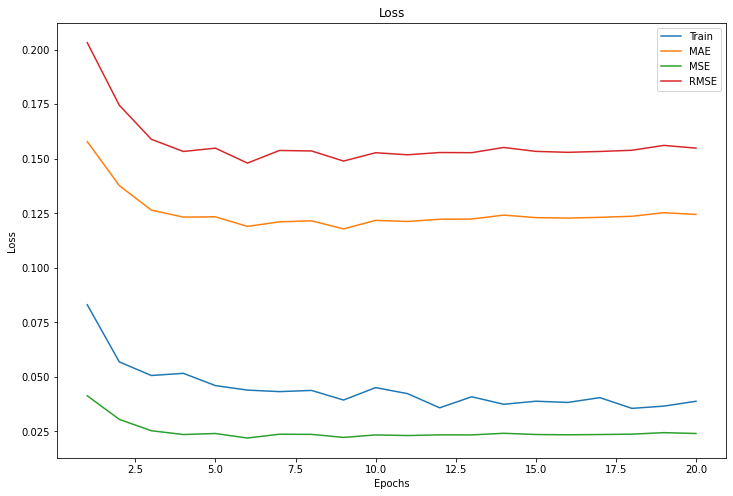

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_fear_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_fear_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_fear_uni_lstm_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 1b
- Fear Dataset
- Bi-LSTM

Size of TEXT vocabulary: 5051
Size of LABEL vocabulary: 266
Top 10 most frequent word in the vocabulary: [('not', 436), ('just', 155), ('like', 140), ('fear', 106), ('amp', 98), ('start', 89), ('terrorism', 84), ('anxiety', 84), ('time', 83), ('make', 81)]
cuda
RNN(
  (embedding): Embedding(5051, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 4,366,629 trainable parameters

Epoch 1: MSE(Train Loss): 0.08782 | MAE(Val. Loss): 0.14723 | MSE(Val. Loss): 0.03477 | RMSE(Val. Loss): 0.18645 | MAPE(Val. Loss): 34.04351% | Time Taken:  0.506s
Epoch 2: MSE(Train Loss): 0.05488 | MAE(Val. Loss): 0.13027 | MSE(Val. Loss): 0.02603 | RMSE(Val. Loss): 0.16135 | MAPE(Val. Loss): 31.59635% | Time Taken:  0.439s
Epoch 3: MSE(Train Loss): 0.05422 | MAE(Val. Loss): 

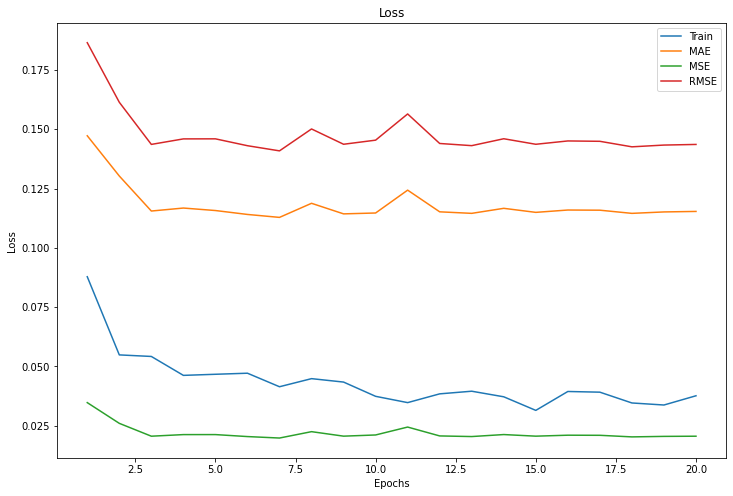

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_fear_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_fear_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_fear_bi_lstm_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 1c
- Fear Dataset
- Uni-GRU

Size of TEXT vocabulary: 5051
Size of LABEL vocabulary: 266
Top 10 most frequent word in the vocabulary: [('not', 436), ('just', 155), ('like', 140), ('fear', 106), ('amp', 98), ('start', 89), ('terrorism', 84), ('anxiety', 84), ('time', 83), ('know', 81)]
cuda
RNN(
  (embedding): Embedding(5051, 300, padding_idx=1)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 2,470,181 trainable parameters

Epoch 1: MSE(Train Loss): 0.08410 | MAE(Val. Loss): 0.15153 | MSE(Val. Loss): 0.03727 | RMSE(Val. Loss): 0.19305 | MAPE(Val. Loss): 33.01358% | Time Taken:  0.342s
Epoch 2: MSE(Train Loss): 0.05761 | MAE(Val. Loss): 0.12912 | MSE(Val. Loss): 0.02681 | RMSE(Val. Loss): 0.16375 | MAPE(Val. Loss): 29.14831% | Time Taken:  0.288s
Epoch 3: MSE(Train Loss): 0.05381 | MAE(Val. Loss): 0.11823 | MSE(Val. Lo

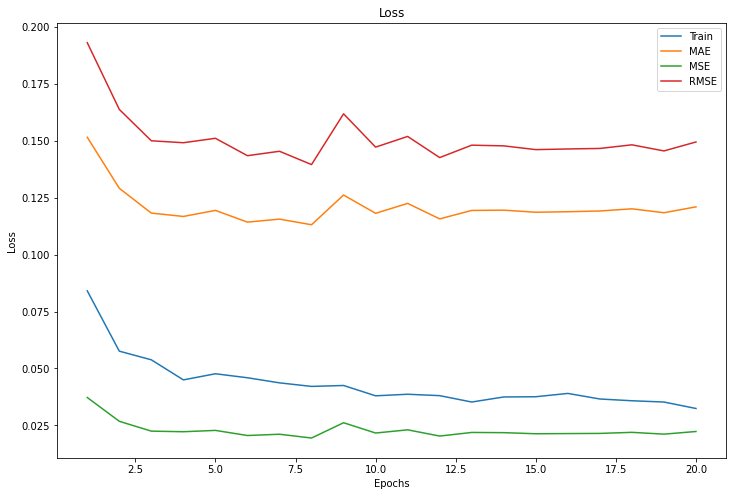

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_fear_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_fear_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_fear_uni_gru_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 1d
- Fear Dataset
- Bi-GRU

Size of TEXT vocabulary: 5051
Size of LABEL vocabulary: 266
Top 10 most frequent word in the vocabulary: [('not', 436), ('just', 155), ('like', 140), ('fear', 106), ('amp', 98), ('start', 89), ('terrorism', 84), ('anxiety', 84), ('time', 83), ('know', 81)]
cuda
RNN(
  (embedding): Embedding(5051, 300, padding_idx=1)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 3,686,693 trainable parameters

Epoch 1: MSE(Train Loss): 0.07632 | MAE(Val. Loss): 0.14653 | MSE(Val. Loss): 0.03371 | RMSE(Val. Loss): 0.18361 | MAPE(Val. Loss): 33.24522% | Time Taken:  0.476s
Epoch 2: MSE(Train Loss): 0.05813 | MAE(Val. Loss): 0.12451 | MSE(Val. Loss): 0.02371 | RMSE(Val. Loss): 0.15398 | MAPE(Val. Loss): 29.78280% | Time Taken:  0.442s
Epoch 3: MSE(Train Loss): 0.05380 | MAE(Val. Loss): 0

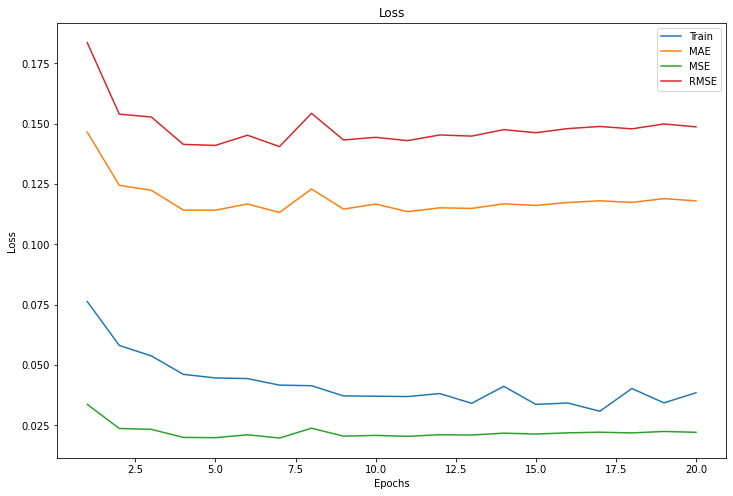

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_fear_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_fear_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_fear_bi_gru_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 2a
- Anger Dataset
- Uni-LSTM

Size of TEXT vocabulary: 2677
Size of LABEL vocabulary: 135
Top 10 most frequent word in the vocabulary: [('not', 171), ('just', 80), ('like', 68), ('anger', 54), ('people', 51), ('rage', 46), ('angry', 45), ('bitter', 44), ('got', 35), ('revenge', 34)]
cuda
RNN(
  (embedding): Embedding(2677, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 2,032,413 trainable parameters

Epoch 1: MSE(Train Loss): 0.13693 | MAE(Val. Loss): 0.16826 | MSE(Val. Loss): 0.04207 | RMSE(Val. Loss): 0.20511 | MAPE(Val. Loss): 39.10654% | Time Taken:  0.138s
Epoch 2: MSE(Train Loss): 0.06063 | MAE(Val. Loss): 0.17043 | MSE(Val. Loss): 0.04379 | RMSE(Val. Loss): 0.20926 | MAPE(Val. Loss): 36.60309% | Time Taken:  0.128s
Validation Loss did not improve count: 1
Epoch 3: MSE(Train Loss): 0.05733 

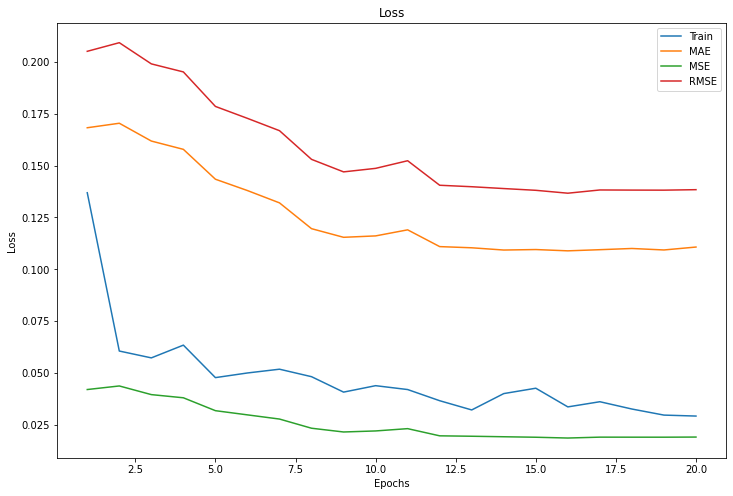

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_anger_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_anger_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_anger_uni_lstm_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 2b
- Anger Dataset
- Bi-LSTM

Size of TEXT vocabulary: 2677
Size of LABEL vocabulary: 135
Top 10 most frequent word in the vocabulary: [('not', 171), ('just', 80), ('like', 68), ('anger', 54), ('people', 51), ('rage', 46), ('angry', 45), ('bitter', 44), ('got', 35), ('revenge', 34)]
cuda
RNN(
  (embedding): Embedding(2677, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 3,654,429 trainable parameters

Epoch 1: MSE(Train Loss): 0.09694 | MAE(Val. Loss): 0.14403 | MSE(Val. Loss): 0.03208 | RMSE(Val. Loss): 0.17911 | MAPE(Val. Loss): 33.48106% | Time Taken:  0.222s
Epoch 2: MSE(Train Loss): 0.05722 | MAE(Val. Loss): 0.13987 | MSE(Val. Loss): 0.03054 | RMSE(Val. Loss): 0.17475 | MAPE(Val. Loss): 32.54683% | Time Taken:  0.189s
Epoch 3: MSE(Train Loss): 0.05351 | MAE(Val. Loss): 0.1

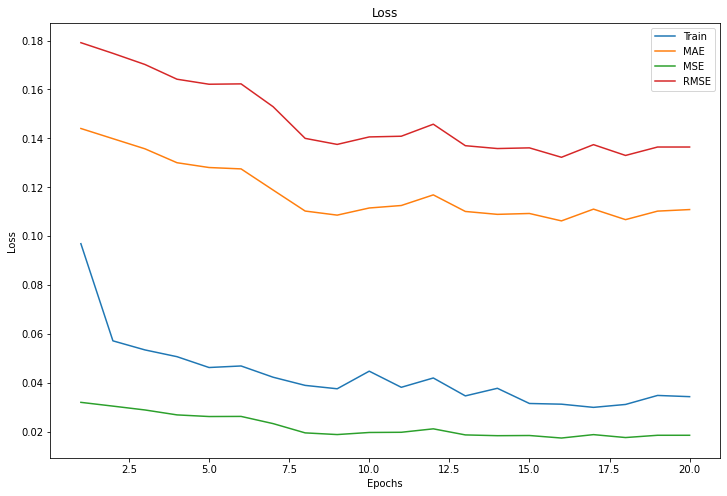

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_anger_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_anger_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_anger_bi_lstm_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 2c
- Anger Dataset
- Uni-GRU

Size of TEXT vocabulary: 2677
Size of LABEL vocabulary: 135
Top 10 most frequent word in the vocabulary: [('not', 171), ('just', 80), ('like', 68), ('anger', 54), ('people', 51), ('rage', 46), ('angry', 45), ('bitter', 44), ('got', 35), ('revenge', 34)]
cuda
RNN(
  (embedding): Embedding(2677, 300, padding_idx=1)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 1,757,981 trainable parameters

Epoch 1: MSE(Train Loss): 0.09385 | MAE(Val. Loss): 0.17564 | MSE(Val. Loss): 0.04745 | RMSE(Val. Loss): 0.21783 | MAPE(Val. Loss): 35.74539% | Time Taken:  0.128s
Epoch 2: MSE(Train Loss): 0.05422 | MAE(Val. Loss): 0.14572 | MSE(Val. Loss): 0.03365 | RMSE(Val. Loss): 0.18343 | MAPE(Val. Loss): 33.51071% | Time Taken:  0.122s
Epoch 3: MSE(Train Loss): 0.05705 | MAE(Val. Loss): 0.14159 | MSE(Val. Loss)

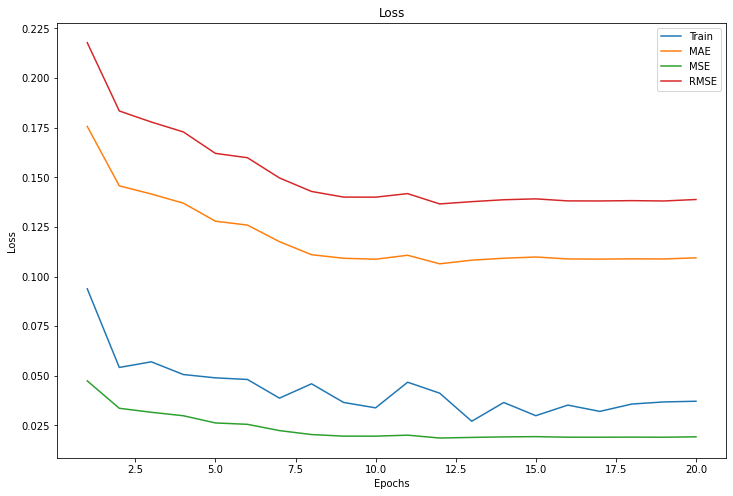

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_anger_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_anger_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_anger_uni_gru_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 2d
- Anger Dataset
- Bi-GRU

Size of TEXT vocabulary: 2677
Size of LABEL vocabulary: 135
Top 10 most frequent word in the vocabulary: [('not', 171), ('just', 80), ('like', 68), ('anger', 54), ('people', 51), ('rage', 46), ('angry', 45), ('bitter', 44), ('got', 35), ('revenge', 34)]
cuda
RNN(
  (embedding): Embedding(2677, 300, padding_idx=1)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 2,974,493 trainable parameters

Epoch 1: MSE(Train Loss): 0.07955 | MAE(Val. Loss): 0.18155 | MSE(Val. Loss): 0.04876 | RMSE(Val. Loss): 0.22081 | MAPE(Val. Loss): 36.40126% | Time Taken:  0.212s
Epoch 2: MSE(Train Loss): 0.05138 | MAE(Val. Loss): 0.15001 | MSE(Val. Loss): 0.03459 | RMSE(Val. Loss): 0.18598 | MAPE(Val. Loss): 32.67731% | Time Taken:  0.175s
Epoch 3: MSE(Train Loss): 0.05400 | MAE(Val. Loss): 0.12

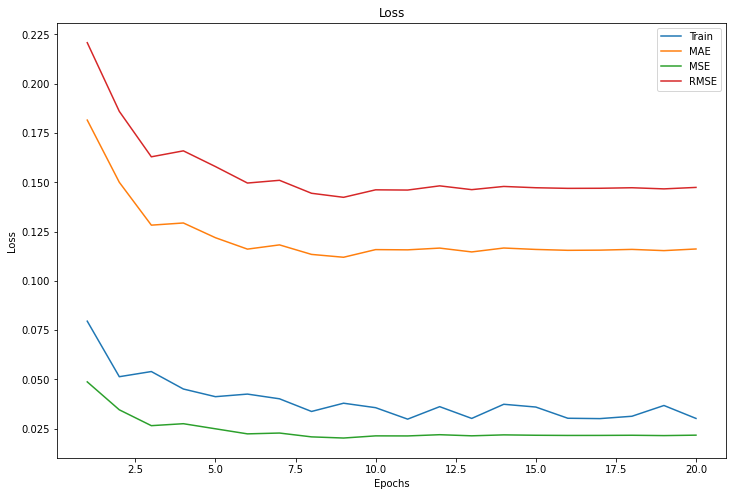

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_anger_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_anger_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_anger_bi_gru_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 3a
- Sadness Dataset
- Uni-LSTM

Size of TEXT vocabulary: 4428
Size of LABEL vocabulary: 214
Top 10 most frequent word in the vocabulary: [('not', 332), ('just', 109), ('sad', 98), ('lost', 89), ('like', 87), ('amp', 83), ('depression', 83), ('blue', 78), ('sadness', 74), ('day', 71)]
cuda
RNN(
  (embedding): Embedding(4428, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 2,557,713 trainable parameters

Epoch 1: MSE(Train Loss): 0.12615 | MAE(Val. Loss): 0.16225 | MSE(Val. Loss): 0.04260 | RMSE(Val. Loss): 0.20640 | MAPE(Val. Loss): 35.11356% | Time Taken:  0.247s
Epoch 2: MSE(Train Loss): 0.05980 | MAE(Val. Loss): 0.13655 | MSE(Val. Loss): 0.03177 | RMSE(Val. Loss): 0.17825 | MAPE(Val. Loss): 32.07089% | Time Taken:  0.217s
Epoch 3: MSE(Train Loss): 0.06061 | MAE(Val. Loss): 0.13080 | MSE(Val. Loss)

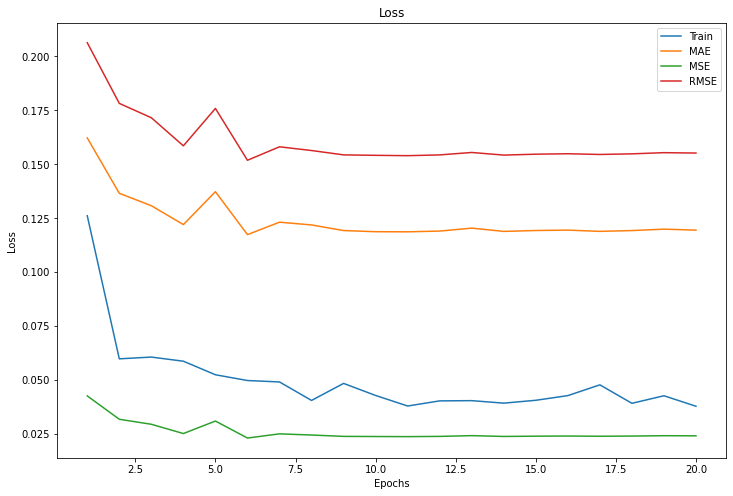

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_sadness_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_sadness_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_sadness_uni_lstm_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 3b
- Sadness Dataset
- Bi-LSTM

Size of TEXT vocabulary: 4428
Size of LABEL vocabulary: 214
Top 10 most frequent word in the vocabulary: [('not', 332), ('just', 109), ('sad', 98), ('lost', 89), ('like', 87), ('amp', 83), ('depression', 83), ('blue', 78), ('sadness', 74), ('day', 71)]
cuda
RNN(
  (embedding): Embedding(4428, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 4,179,729 trainable parameters

Epoch 1: MSE(Train Loss): 0.09914 | MAE(Val. Loss): 0.15216 | MSE(Val. Loss): 0.03922 | RMSE(Val. Loss): 0.19804 | MAPE(Val. Loss): 34.04384% | Time Taken:  0.374s
Epoch 2: MSE(Train Loss): 0.06143 | MAE(Val. Loss): 0.13465 | MSE(Val. Loss): 0.03096 | RMSE(Val. Loss): 0.17595 | MAPE(Val. Loss): 32.42060% | Time Taken:  0.304s
Epoch 3: MSE(Train Loss): 0.05708 | MAE(Val. Loss): 0.12

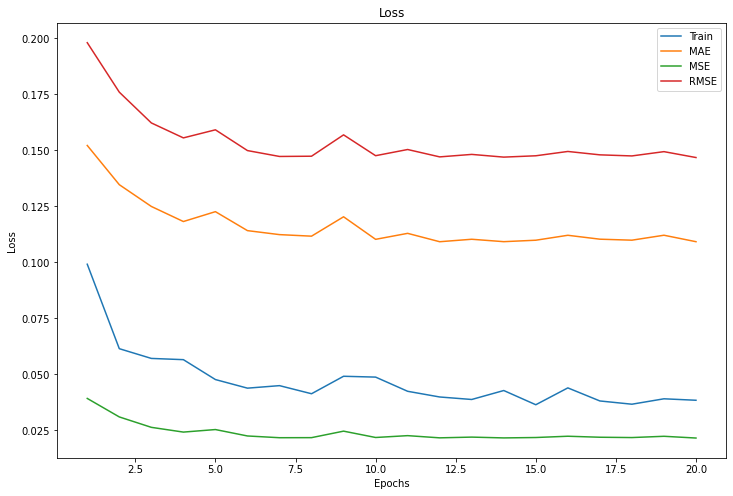

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_sadness_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_sadness_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_sadness_bi_lstm_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 3c
- Sadness Dataset
- Uni-GRU

Size of TEXT vocabulary: 4428
Size of LABEL vocabulary: 214
Top 10 most frequent word in the vocabulary: [('not', 332), ('just', 109), ('sad', 98), ('lost', 89), ('like', 87), ('depression', 83), ('amp', 83), ('blue', 78), ('sadness', 74), ('time', 71)]
cuda
RNN(
  (embedding): Embedding(4428, 300, padding_idx=1)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 2,283,281 trainable parameters

Epoch 1: MSE(Train Loss): 0.09493 | MAE(Val. Loss): 0.14899 | MSE(Val. Loss): 0.03720 | RMSE(Val. Loss): 0.19286 | MAPE(Val. Loss): 33.55946% | Time Taken:  0.227s
Epoch 2: MSE(Train Loss): 0.05953 | MAE(Val. Loss): 0.12630 | MSE(Val. Loss): 0.02728 | RMSE(Val. Loss): 0.16518 | MAPE(Val. Loss): 31.18361% | Time Taken:  0.206s
Epoch 3: MSE(Train Loss): 0.05137 | MAE(Val. Loss): 0.13500 | MSE(Val. Loss)

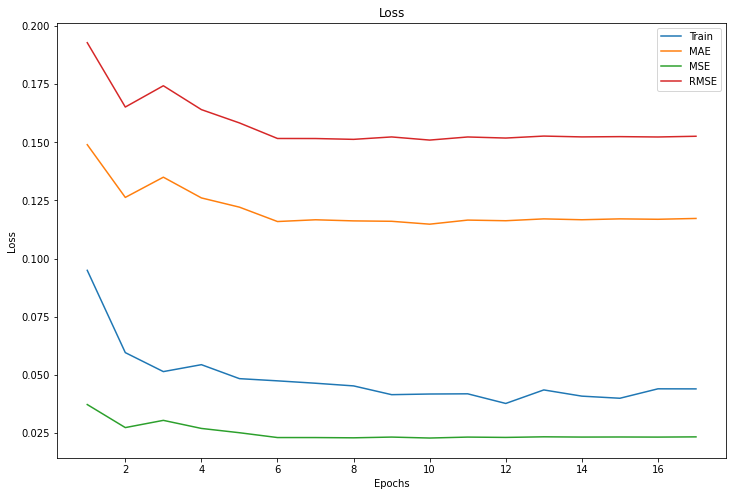

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_sadness_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_sadness_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_sadness_uni_gru_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = False # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

### CONFIGURATION 3d
- Sadness Dataset
- Bi-GRU

Size of TEXT vocabulary: 4428
Size of LABEL vocabulary: 214
Top 10 most frequent word in the vocabulary: [('not', 332), ('just', 109), ('sad', 98), ('lost', 89), ('like', 87), ('depression', 83), ('amp', 83), ('blue', 78), ('sadness', 74), ('day', 71)]
cuda
RNN(
  (embedding): Embedding(4428, 300, padding_idx=1)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
The model has 3,499,793 trainable parameters

Epoch 1: MSE(Train Loss): 0.07833 | MAE(Val. Loss): 0.13508 | MSE(Val. Loss): 0.03173 | RMSE(Val. Loss): 0.17812 | MAPE(Val. Loss): 32.00163% | Time Taken:  0.330s
Epoch 2: MSE(Train Loss): 0.05496 | MAE(Val. Loss): 0.12225 | MSE(Val. Loss): 0.02578 | RMSE(Val. Loss): 0.16057 | MAPE(Val. Loss): 30.26700% | Time Taken:  0.301s
Epoch 3: MSE(Train Loss): 0.04600 | MAE(Val. Loss): 0.123

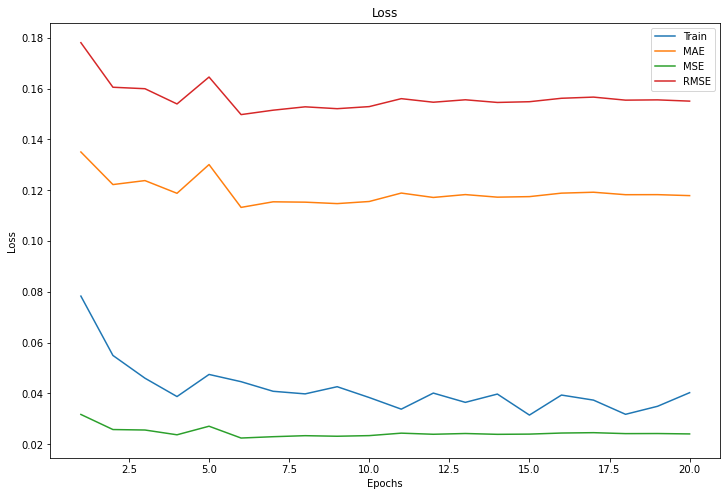

In [ ]:
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_sadness_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_sadness_combined_dev.csv', 
                                                                   batch_size=32)
MODEL_NAME = 'emotion_intensity_sadness_bi_gru_model.pt'
# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'gru' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

#creating instance of our LSTM_net class
model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)
# see the model description
print(model)
    
print(f'The model has {count_parameters(model):,} trainable parameters')
print()

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# fit the model
fit_model(model=model,
          device=device,
          learning_rate=LEARNING_RATE,
          num_epochs=NUM_EPOCHS,
          root_path=SAVED_MODEL_PATH, 
          filepath=MODEL_NAME)

## Predict with own sentences

In [ ]:
def predict(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to('cpu')              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    
    prediction = model(tensor, length_tensor).squeeze(1)       #prediction 

    #rounded_preds = 1-torch.sigmoid(prediction) #torch.round(torch.sigmoid(prediction))
    #predict_class = rounded_preds.tolist()[0]
    #return predict_class 
    return prediction

In [ ]:
# sample test sentence
# test_sen1 = "I don't want speak front to him #afraid #intimidate #nopanicattack"
# predict_class_1 = predict(model, test_sen1) 
# print(predict_class_1)

In [ ]:
# load short and long datasets (test sets) for predictions
test_data_short = pd.read_csv(DATA_PATH+'emotion_intensity_depressed_clean_short_data_test.csv')
test_data_long = pd.read_csv(DATA_PATH+'emotion_intensity_depressed_clean_long_data_test.csv')

# create dataframes to store the emotion intensity scores for both the short and long text data
emotion_intensity_pred_short = pd.DataFrame()
emotion_intensity_pred_long = pd.DataFrame()

# initialise the dataframe
emotion_intensity_pred_short['Text'] = test_data_short['Text']
emotion_intensity_pred_short['text_cleaned'] = test_data_short['text_cleaned']
emotion_intensity_pred_long['Text'] = test_data_long['Text']
emotion_intensity_pred_long['text_cleaned'] = test_data_long['text_cleaned']

## Predict based on best model on Fear

In [ ]:
# redeclare the model
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_fear_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_fear_combined_dev.csv', 
                                                                   batch_size=32)

# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

# model path for the fear category
PATH = SAVED_MODEL_PATH+'emotion_intensity_fear_bi_lstm_model.pt'
model.load_state_dict(torch.load(PATH))

Size of TEXT vocabulary: 5051
Size of LABEL vocabulary: 266
Top 10 most frequent word in the vocabulary: [('not', 436), ('just', 155), ('like', 140), ('fear', 106), ('amp', 98), ('start', 89), ('anxiety', 84), ('terrorism', 84), ('time', 83), ('make', 81)]
cuda


<All keys matched successfully>

In [ ]:
# get prediction for short data
pred_list_short = []

for i in tqdm(test_data_short['text_cleaned']):
    predicted_value = predict(model, i) 
    pred_list_short.append(predicted_value.item())

print('\n')
print(max(pred_list_short))
print(min(pred_list_short))

100%|██████████| 834/834 [00:04<00:00, 203.11it/s]



0.8632298111915588
0.18671295046806335


In [ ]:
# get prediction for long data
pred_list_long = []

for i in tqdm(test_data_long['text_cleaned']):
    predicted_value = predict(model, i) 
    pred_list_long.append(predicted_value.item())

print('\n')
print(max(pred_list_long))
print(min(pred_list_long))

100%|██████████| 1436/1436 [01:10<00:00, 20.30it/s]



0.790759265422821
0.14436019957065582


In [ ]:
# append scores to dataframe
emotion_intensity_pred_short['fear_score'] = pred_list_short
emotion_intensity_pred_long['fear_score'] = pred_list_long

## Predict based on best model on Anger

In [ ]:
# redeclare the model
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_anger_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_anger_combined_dev.csv', 
                                                                   batch_size=32)

# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

# model path for the fear category
PATH = SAVED_MODEL_PATH+'emotion_intensity_anger_bi_lstm_model.pt'
model.load_state_dict(torch.load(PATH))

Size of TEXT vocabulary: 2677
Size of LABEL vocabulary: 135
Top 10 most frequent word in the vocabulary: [('not', 171), ('just', 80), ('like', 68), ('anger', 54), ('people', 51), ('rage', 46), ('angry', 45), ('bitter', 44), ('got', 35), ('revenge', 34)]
cuda


<All keys matched successfully>

In [ ]:
# get prediction for short data
pred_list_short = []

for i in tqdm(test_data_short['text_cleaned']):
    predicted_value = predict(model, i) 
    pred_list_short.append(predicted_value.item())

print('\n')
print(max(pred_list_short))
print(min(pred_list_short))

100%|██████████| 834/834 [00:04<00:00, 196.55it/s]



1.1089589595794678
0.16907501220703125


In [ ]:
# max value more than one hence need to cap it to 1
pred_list_short_final = []
for pred in pred_list_short:
  if pred < 0:
    pred_list_short_final.append(0)
  elif pred > 1.0:
    pred_list_short_final.append(1.0)
  else:
    pred_list_short_final.append(pred)

print('\n')
print(max(pred_list_short_final))
print(min(pred_list_short_final))



1.0
0.16907501220703125


In [ ]:
# get prediction for long data
pred_list_long = []

for i in tqdm(test_data_long['text_cleaned']):
    predicted_value = predict(model, i) 
    pred_list_long.append(predicted_value.item())

print('\n')
print(max(pred_list_long))
print(min(pred_list_long))

100%|██████████| 1436/1436 [01:11<00:00, 20.21it/s]



0.9099479913711548
0.09526021033525467


In [ ]:
# append scores to dataframe
emotion_intensity_pred_short['angry_score'] = pred_list_short
emotion_intensity_pred_long['angry_score'] = pred_list_long

## Predict based on best model on Sadness

In [ ]:
# redeclare the model
# call the data handler to load the data
TEXT, LABEL, device, train_iterator, valid_iterator = data_handler(DATA_PATH, 
                                                                   train_data_filename='emotion_intensity_wassa_sadness_combined_train.csv', 
                                                                   val_data_filename='emotion_intensity_wassa_sadness_combined_dev.csv', 
                                                                   batch_size=32)

# Hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-04

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2 
BIDIRECTIONAL = True # changeable
RNN_TYPE = 'lstm' # changeable
DROPOUT = 0.1
# padding
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] 

model = RNN(vocab_size=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            output_dim=OUTPUT_DIM, 
            n_layers=N_LAYERS, 
            bidirectional=BIDIRECTIONAL, 
            rnn_type=RNN_TYPE,
            dropout=DROPOUT, 
            pad_idx=PAD_IDX)

# model path for the fear category
PATH = SAVED_MODEL_PATH+'emotion_intensity_sadness_bi_lstm_model.pt'
model.load_state_dict(torch.load(PATH))

Size of TEXT vocabulary: 4428
Size of LABEL vocabulary: 214
Top 10 most frequent word in the vocabulary: [('not', 332), ('just', 109), ('sad', 98), ('lost', 89), ('like', 87), ('depression', 83), ('amp', 83), ('blue', 78), ('sadness', 74), ('day', 71)]
cuda


<All keys matched successfully>

In [ ]:
# get prediction for short data
pred_list_short = []

for i in tqdm(test_data_short['text_cleaned']):
    predicted_value = predict(model, i) 
    pred_list_short.append(predicted_value.item())

print('\n')
print(max(pred_list_short))
print(min(pred_list_short))

100%|██████████| 834/834 [00:04<00:00, 200.28it/s]



0.9413471817970276
0.20213745534420013


In [ ]:
# get prediction for long data
pred_list_long = []

for i in tqdm(test_data_long['text_cleaned']):
    predicted_value = predict(model, i) 
    pred_list_long.append(predicted_value.item())

print('\n')
print(max(pred_list_long))
print(min(pred_list_long))

100%|██████████| 1436/1436 [01:11<00:00, 20.13it/s]



0.8846503496170044
0.24033287167549133


In [ ]:
# append scores to dataframe
emotion_intensity_pred_short['sadness_score'] = pred_list_short
emotion_intensity_pred_long['sadness_score'] = pred_list_long

## Check DataFrame

In [ ]:
emotion_intensity_pred_short.head()

,Text,text_cleaned,fear_score,angry_score,sadness_score
0,I get to spend New Year's home again alone and...,spend new year home lonely,0.367257,0.340932,0.604463
1,"Depressed and lonely /: Stuck in a deep, never...",depressed lonely stuck deep ending hole,0.453489,0.493586,0.590169
2,Learning to pretend to have a good time had be...,learning pretend good time natural skill hope ...,0.256979,0.306531,0.408736
3,So far he stop texting me…after I said somethi...,far stop texting meafter said somethingso hope...,0.458516,0.475224,0.408144
4,*sigh* ???? I haven't cried so much…I'm in so ...,sigh not cried muchi pain,0.527133,0.438837,0.559635


In [ ]:
emotion_intensity_pred_long.head()

,Text,text_cleaned,fear_score,angry_score,sadness_score
0,Just another night. Another night of feeling l...,just night night feeling lonely just wondering...,0.501568,0.422321,0.498666
1,Is it possible to fake depression? I have been...,possible fake depression feeling bad month now...,0.634426,0.493567,0.724639
2,Imagine being attractive Imagine what it would...,imagine attractive imagine like desired look n...,0.407223,0.595135,0.452349
3,"Best moment to have anxiety It's 3:30am, I'm t...",best moment anxiety am tired want early guess ...,0.501608,0.404472,0.483677
4,"hi, I'm a 21 year-old male from the uk, over t...",hi yearold male uk past month increasingly dep...,0.383745,0.449346,0.483427


## Export the dataframe with the emotion intensities

In [ ]:
emotion_intensity_pred_short.to_csv(DATA_PATH+'emotion_intensity_feature_based_prediction_scoring_short_data.csv', index=False)
emotion_intensity_pred_long.to_csv(DATA_PATH+'emotion_intensity_feature_based_prediction_scoring_long_data.csv', index=False)